<a href="https://colab.research.google.com/github/CoderAPS/neural_nets/blob/main/cell_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#source1: https://www.kaggle.com/code/vbookshelf/simple-cell-segmentation-with-keras-and-u-net

#source2: https://www.kaggle.com/code/keegil/keras-u-net-starter-lb-0-277/notebook


# possible reads
#1: https://divamgupta.com/image-segmentation/2019/06/06/deep-learning-semantic-segmentation-keras.html 
#2: laod image with masks ==> https://stackoverflow.com/questions/72388029/how-to-deal-with-images-and-masks-using-tf-dataset-in-a-semantic-segmentation-ta

In [ ]:
# data source: https://www.kaggle.com/datasets/vbookshelf/synthetic-cell-images-and-masks-bbbc005-v1

In [1]:
# Google drive path to source data
!ls drive/MyDrive/Colab/data/

cifar-10-batches-py  nuclei  synthetic_cells


In [2]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread, imshow
from skimage.transform import resize

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import Concatenate # original code was: from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

In [3]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 1

NUM_TEST_IMAGES = 10


In [4]:
!ls drive/MyDrive/Colab/data/synthetic_cells/BBBC005_v1_images

BBBC005_v1_images


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
path = 'drive/MyDrive/Colab/data/synthetic_cells'

In [8]:
# this code error due to how colab is setup
# get a list of files in each folder

img_list = os.listdir(path + '/BBBC005_v1_images/BBBC005_v1_images')
mask_list = os.listdir(path + '/BBBC005_v1_ground_truth/BBBC005_v1_ground_truth')

# create a dataframe
df_images = pd.DataFrame(img_list, columns=['image_id'])

# filter out the non image file that's called .htaccess
df_images = df_images[df_images['image_id'] != '.htaccess']



# Example file name: SIMCEPImages_A13_C53_F1_s23_w2.TIF


# ======================================================
# Add a column showing how many cells are on each image
# ======================================================

def get_num_cells(x):
    # split on the _
    a = x.split('_')
    # choose the third item
    b = a[2] # e.g. C53
    # choose second item onwards and convert to int
    num_cells = int(b[1:])
    
    return num_cells

# create a new column called 'num_cells'
df_images['num_cells'] = df_images['image_id'].apply(get_num_cells)


# ================================================
# Add a column indicating if an image has a mask.
# ================================================

# Keep in mind images and masks have the same file names.

def check_for_mask(x):
    if x in mask_list:
        return 'yes'
    else:
        return 'no'
    
# create a new column called 'has_mask'
df_images['has_mask'] = df_images['image_id'].apply(check_for_mask)



# ===========================================================
# Add a column showing how much blur was added to each image
# ===========================================================

def get_blur_amt(x):
    # split on the _
    a = x.split('_')
    # choose the third item
    b = a[3] # e.g. F1
    # choose second item onwards and convert to int
    blur_amt = int(b[1:])
    
    return blur_amt

# create a new column called 'blur_amt'
df_images['blur_amt'] = df_images['image_id'].apply(get_blur_amt)


In [19]:
df_images.to_csv(path + '/df_images_saved.csv')

In [20]:
!ls {path}

BBBC005_v1_ground_truth  BBBC005_v1_images  df_images_saved.csv


In [21]:
df_images.head(10)

,image_id,num_cells,has_mask,blur_amt
0,SIMCEPImages_P06_C23_F48_s23_w2.TIF,23,no,48
1,SIMCEPImages_P06_C23_F48_s17_w2.TIF,23,no,48
2,SIMCEPImages_P05_C18_F48_s24_w2.TIF,18,no,48
3,SIMCEPImages_P04_C14_F48_s22_w2.TIF,14,no,48
4,SIMCEPImages_P05_C18_F48_s08_w2.TIF,18,no,48
5,SIMCEPImages_P05_C18_F48_s06_w1.TIF,18,no,48
6,SIMCEPImages_P06_C23_F48_s08_w2.TIF,23,no,48
7,SIMCEPImages_P06_C23_F48_s09_w2.TIF,23,no,48
8,SIMCEPImages_P04_C14_F48_s04_w1.TIF,14,no,48
9,SIMCEPImages_P06_C23_F48_s14_w2.TIF,23,no,48


In [22]:
# Filter images that have masks
df_masks = df_images[df_images['has_mask'] == 'yes']

# create a new column called mask_id that is just a copy of image_id
df_masks['mask_id'] = df_masks['image_id']

df_masks.shape

(1200, 5)

In [23]:
df_masks.head()

,image_id,num_cells,has_mask,blur_amt,mask_id
18000,SIMCEPImages_A06_C23_F1_s04_w2.TIF,23,yes,1,SIMCEPImages_A06_C23_F1_s04_w2.TIF
18001,SIMCEPImages_A06_C23_F1_s15_w1.TIF,23,yes,1,SIMCEPImages_A06_C23_F1_s15_w1.TIF
18002,SIMCEPImages_A06_C23_F1_s02_w2.TIF,23,yes,1,SIMCEPImages_A06_C23_F1_s02_w2.TIF
18003,SIMCEPImages_A06_C23_F1_s13_w1.TIF,23,yes,1,SIMCEPImages_A06_C23_F1_s13_w1.TIF
18004,SIMCEPImages_A06_C23_F1_s10_w2.TIF,23,yes,1,SIMCEPImages_A06_C23_F1_s10_w2.TIF


In [24]:
# Here we will create a test set containing 10 images. Keras will 
# automatically create a validation set during training.

# create a test set
df_test = df_masks.sample(NUM_TEST_IMAGES, random_state=101)
print(df_test)
# Reset the index.
# This is so that we can use loc to access mask id's later.
df_test = df_test.reset_index(drop=True)

# create a list of test images
test_images_list = list(df_test['image_id'])


# Select only rows that are not part of the test set.
# Note the use of ~ to execute 'not in'.
df_masks = df_masks[~df_masks['image_id'].isin(test_images_list)]

print(df_masks.shape)
print(df_test.shape)

                                  image_id  num_cells has_mask  blur_amt  \
19052    SIMCEPImages_A02_C5_F1_s16_w2.TIF          5      yes         1   
18754   SIMCEPImages_A21_C87_F1_s13_w1.TIF         87      yes         1   
18436   SIMCEPImages_A15_C61_F1_s06_w1.TIF         61      yes         1   
19004    SIMCEPImages_A01_C1_F1_s04_w1.TIF          1      yes         1   
18296   SIMCEPImages_A11_C44_F1_s20_w2.TIF         44      yes         1   
18902  SIMCEPImages_A24_C100_F1_s09_w1.TIF        100      yes         1   
18002   SIMCEPImages_A06_C23_F1_s02_w2.TIF         23      yes         1   
19255   SIMCEPImages_A06_C23_F1_s08_w1.TIF         23      yes         1   
18869   SIMCEPImages_A23_C96_F1_s04_w2.TIF         96      yes         1   
19232   SIMCEPImages_A05_C18_F1_s14_w2.TIF         18      yes         1   

                                   mask_id  
19052    SIMCEPImages_A02_C5_F1_s16_w2.TIF  
18754   SIMCEPImages_A21_C87_F1_s13_w1.TIF  
18436   SIMCEPImages_A15_C61



Here we want to find out:<b>

    1. What are the shapes?
    2. Is the image rgb or black and white?

We need this info to write the code that will process the images and masks into a format that the model requires.


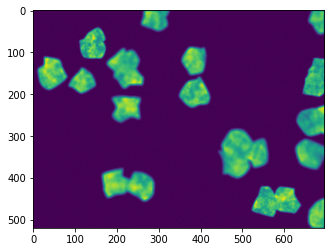

In [25]:
#

sample_image = 'SIMCEPImages_A06_C23_F1_s11_w2.TIF'
path_image = path+'/BBBC005_v1_images/BBBC005_v1_images/' + sample_image

# read the image using skimage
image = imread(path_image)

plt.imshow(image);

In [26]:
print('Shape: ', image.shape)
print('Max pixel value: ', image.max())
print('Min pixel value: ', image.min())
np.unique(image,return_counts=True)

Shape:  (520, 696)
Max pixel value:  222
Min pixel value:  0


(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

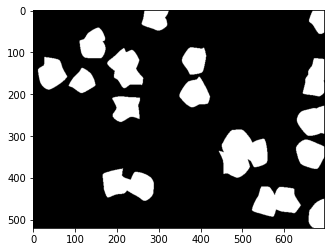

In [27]:
sample_mask = 'SIMCEPImages_A06_C23_F1_s11_w2.TIF'
path_mask = path+'/BBBC005_v1_ground_truth/BBBC005_v1_ground_truth/' + sample_mask

# read the mask using skimage
mask = imread(path_mask)

plt.imshow(mask, cmap='gray');

In [28]:
print('Shape: ', mask.shape)
print('Max pixel value: ', mask.max())
print('Min pixel value: ', mask.min())
np.unique(mask,return_counts=True)

Shape:  (520, 696)
Max pixel value:  255
Min pixel value:  0


(array([  0, 255], dtype=uint8), array([299482,  62438]))



The image and its associated mask have the same shape. We see that the image is 2D and not 3D. The mask is 2D. The image has pixel values in the range 0 to 255. The mask has pixel values that are either 0 or 255. 0 is black and 255 is white.

The model requires this input format:

(num_samples, num_rows, num_columns, num_channels)

Therefore, we will need to use np.expand_dims to add a channel dimension to both the image and the mask.

Also, the model expects input images and masks to have the same width and height. We will therefore resize both images and the masks to 128 x 128.


In [29]:
# Get lists of images and their masks.
image_id_list = list(df_masks['image_id'])
mask_id_list = list(df_masks['mask_id'])
test_id_list = list(df_test['image_id'])

# Create empty arrays

X_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), 
                   dtype=np.uint8)

Y_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, 1), 
                   dtype=np.bool)

X_test = np.zeros((NUM_TEST_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), 
                  dtype=np.uint8)

In [30]:
# These arrays currently populated all with zeros
# The respective details get copied the following code
print(f'X_train shape: {X_train.shape}')
print(f'Y_train shape: {Y_train.shape}')
print(f'X_test shape: {X_test.shape}')


X_train shape: (1190, 128, 128, 1)
Y_train shape: (1190, 128, 128, 1)
X_test shape: (10, 128, 128, 1)


In [31]:
for i, image_id in tqdm(enumerate(image_id_list),
                        total=len(image_id_list)):
    
    path_image = path+ '/BBBC005_v1_images/BBBC005_v1_images/' + image_id
    
    # read the image using skimage
    image = imread(path_image)
    
    # resize the image
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                   preserve_range=True)
    
    # use np.expand dims to add a channel axis so the shape becomes 
    # (IMG_HEIGHT, IMG_WIDTH, 1)
    image = np.expand_dims(image, axis=-1)
    
    # insert the image into X_train
    X_train[i] = image
    
X_train.shape

100%|██████████| 1190/1190 [10:39<00:00,  1.86it/s]


(1190, 128, 128, 1)

In [32]:
# Y_train


for i, mask_id in tqdm(enumerate(mask_id_list),total=len(mask_id_list)):
    
    path_mask = path + '/BBBC005_v1_ground_truth/BBBC005_v1_ground_truth/' + mask_id
    
    # read the image using skimage
    mask = imread(path_mask)
    
    # resize the image
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    mask = np.expand_dims(mask, axis=-1)
    
    # insert the image into Y_Train
    Y_train[i] = mask

Y_train.shape

100%|██████████| 1190/1190 [09:34<00:00,  2.07it/s]


(1190, 128, 128, 1)

In [33]:
# X_test

for i, image_id in tqdm(enumerate(test_id_list),total=len(test_id_list)):
    
    path_image = path + '/BBBC005_v1_images/BBBC005_v1_images/' + image_id
    
    # read the image using skimage
    image = imread(path_image)
    
    # resize the image
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    image = np.expand_dims(image, axis=-1)
    
    # insert the image into X_test
    X_test[i] = image
    
X_test.shape

100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


(10, 128, 128, 1)

In [36]:
# source: https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277


inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', 
            padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', 
            padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', 
            padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', 
            padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', 
            padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', 
            padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', 
            padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', 
            padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', 
            padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', 
            padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = Concatenate()([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', 
            padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = Concatenate()([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = Concatenate()([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = Concatenate(axis=3)([u9, c1])
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['Accuracy','BinaryIoU'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda_2 (Lambda)              (None, 128, 128, 1)  0           ['input_3[0][0]']                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 128, 128, 16  160         ['lambda_2[0][0]']               
                                )                                                                 
                                                                                            

In [37]:
filepath = "model.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

callbacks_list = [earlystopper, checkpoint]

history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=callbacks_list)

Epoch 1/50
67/67 [==============================] - ETA: 0s - loss: 0.1015 - Accuracy: 0.9557 - binary_io_u: 0.9062
Epoch 1: val_loss improved from inf to 0.01451, saving model to model.h5
67/67 [==============================] - 23s 87ms/step - loss: 0.1015 - Accuracy: 0.9557 - binary_io_u: 0.9062 - val_loss: 0.0145 - val_Accuracy: 0.9941 - val_binary_io_u: 0.9730
Epoch 2/50
67/67 [==============================] - ETA: 0s - loss: 0.0322 - Accuracy: 0.9864 - binary_io_u: 0.9701
Epoch 2: val_loss improved from 0.01451 to 0.01015, saving model to model.h5
67/67 [==============================] - 3s 52ms/step - loss: 0.0322 - Accuracy: 0.9864 - binary_io_u: 0.9701 - val_loss: 0.0102 - val_Accuracy: 0.9959 - val_binary_io_u: 0.9812
Epoch 3/50
67/67 [==============================] - ETA: 0s - loss: 0.0255 - Accuracy: 0.9891 - binary_io_u: 0.9760
Epoch 3: val_loss improved from 0.01015 to 0.00842, saving model to model.h5
67/67 [==============================] - 3s 52ms/step - loss: 0.0255

In [38]:
# Make a prediction

# use the best epoch
model.load_weights('model.h5')

test_preds = model.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [44]:
test_preds[0]

array([[[7.2427308e-03],
        [8.6925138e-04],
        [2.9674766e-04],
        ...,
        [2.9385125e-04],
        [5.5944402e-04],
        [7.9170670e-03]],

       [[6.9298205e-04],
        [2.2371320e-05],
        [4.9535092e-06],
        ...,
        [3.8435933e-06],
        [1.7990964e-05],
        [1.1700947e-03]],

       [[1.7625422e-04],
        [5.4682541e-06],
        [6.5123584e-07],
        ...,
        [9.9410533e-07],
        [4.6526029e-06],
        [4.4557740e-04]],

       ...,

       [[1.9114533e-04],
        [3.3693152e-06],
        [9.1175968e-07],
        ...,
        [1.0000000e+00],
        [1.0000000e+00],
        [9.9999905e-01]],

       [[4.3151795e-04],
        [1.8736606e-05],
        [4.6632777e-06],
        ...,
        [1.0000000e+00],
        [1.0000000e+00],
        [9.9999833e-01]],

       [[7.8020571e-03],
        [6.8406016e-04],
        [3.4759706e-04],
        ...,
        [1.0000000e+00],
        [9.9999976e-01],
        [9.9975997e-01]]

In [45]:
# Threshold the predictions

preds_test_thresh = (test_preds >= 0.5).astype(np.uint8)


In [50]:
preds_test_thresh.shape

(10, 128, 128, 1)

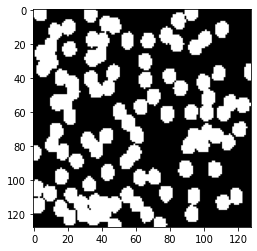

In [56]:
# Display a thresholded mask

test_img = preds_test_thresh[5, :, :, 0]

plt.imshow(test_img, cmap='gray');

Here we will display 3 test images, their true masks and the masks that the model predicted for those images.

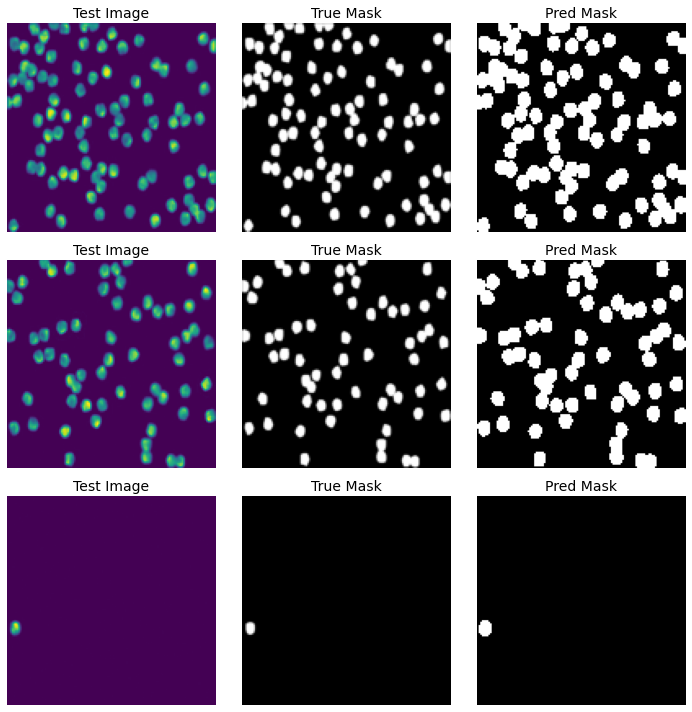

In [58]:
# set up the canvas for the subplots
plt.figure(figsize=(10,10))
plt.axis('Off')

# Our subplot will contain 3 rows and 3 columns
# plt.subplot(nrows, ncols, plot_number)


# == row 1 ==

# image
plt.subplot(3,3,1)
test_image = X_test[1, :, :, 0]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')

# true mask
plt.subplot(3,3,2)
mask_id = df_test.loc[1,'mask_id']
path_mask = path + '/BBBC005_v1_ground_truth/BBBC005_v1_ground_truth/' + mask_id
mask = imread(path_mask)
mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# predicted mask
plt.subplot(3,3,3)
test_mask = preds_test_thresh[1, :, :, 0]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')

# == row 2 ==

# image
plt.subplot(3,3,4)
test_image = X_test[2, :, :, 0]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')


# true mask
plt.subplot(3,3,5)
mask_id = df_test.loc[2,'mask_id']
path_mask = path + '/BBBC005_v1_ground_truth/BBBC005_v1_ground_truth/' + mask_id
mask = imread(path_mask)
mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# predicted mask
plt.subplot(3,3,6)
test_mask = preds_test_thresh[2, :, :, 0]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')

# == row 3 ==

# image
plt.subplot(3,3,7)
test_image = X_test[3, :, :, 0]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')

# true mask
plt.subplot(3,3,8)
mask_id = df_test.loc[3,'mask_id']
path_mask = path + '/BBBC005_v1_ground_truth/BBBC005_v1_ground_truth/' + mask_id
mask = imread(path_mask)
mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# predicted mask
plt.subplot(3,3,9)
test_mask = preds_test_thresh[3, :, :, 0]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.show()